In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load data
file_path = '/Users/celestetranbahuy/Desktop/AppliedMath/PseudoData.csv'
data = pd.read_csv(file_path, parse_dates=["call_datetime"])

# Number of days to forecast
n_forecast = 7

# Pre-process data
data['call_date'] = data['call_datetime'].dt.date               # Extract date (day)
daily_calls = data.groupby('call_date').size()                  # Count number of call per day
daily_calls.index = pd.to_datetime(daily_calls.index)           # Index with datetime

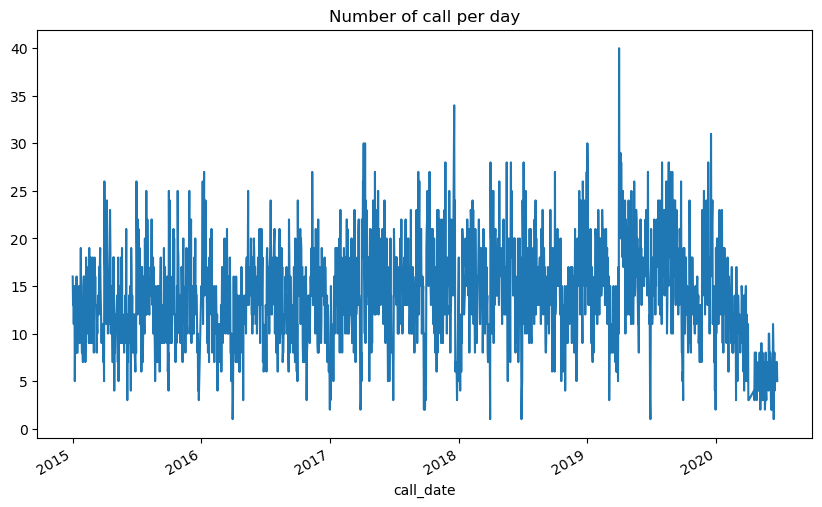

In [7]:
# Visualize daily calls
daily_calls.plot(title='Number of call per day', figsize=(10, 6))
plt.show()

In [8]:
# Prepare data for the Linear Regression
daily_calls_df = daily_calls.reset_index()
daily_calls_df.columns = ['date', 'calls']
daily_calls_df['days'] = (daily_calls_df['date'] - daily_calls_df['date'].min()).dt.days

# Linear Regression
X = daily_calls_df[['days']]
y = daily_calls_df['calls']
model_lr = LinearRegression().fit(X, y)

# 7-day Forecast
future_days = np.arange(daily_calls_df['days'].max() + 1, daily_calls_df['days'].max() + n_forecast + 1).reshape(-1, 1)
predictions_lr = model_lr.predict(future_days)

In [ ]:
# ARIMA
#parameters p
    # p = 2
    #PACF spike at lag 0 1 2, less significant afterwards
    # value of Xt influence by lag 1 mainly, less strickingly lag 2 still important decrease after that 

#parameters d
    # data already stationary 
    # p avlue ADF < 0.05
    # d = 0

#parameters q
    # q = 0
    # we can see gradual decay in the ACF
    # no clear cut off, model doe not need use residual errors to predict current value

model_arima = ARIMA(daily_calls, order=(5, 0, 0))  # Example with (5, 1, 0)
arima_fit = model_arima.fit()
predictions_arima = arima_fit.forecast(steps=n_forecast)

In [10]:
# SARIMA
model_sarima = ARIMA(daily_calls, order=(5, 1, 0), seasonal_order=(5, 1, 0, 7))  # Example with weekly seasonality
sarima_fit = model_sarima.fit()
predictions_sarima = sarima_fit.forecast(steps=n_forecast)

In [11]:
# Forecasts results
forecast_dates = pd.date_range(start=daily_calls.index[-1] + pd.Timedelta(days=1), periods=n_forecast)
results = pd.DataFrame({
    'Date': forecast_dates,
    'Linear_Regression': predictions_lr,
    'ARIMA': predictions_arima,
    'SARIMA': predictions_sarima
})
print(results)

           Date  Linear_Regression     ARIMA    SARIMA
1969 2020-06-24          14.643107  5.860292  6.317633
1970 2020-06-25          14.643669  5.595641  6.548180
1971 2020-06-26          14.644230  5.744120  5.919135
1972 2020-06-27          14.644791  5.645034  5.286980
1973 2020-06-28          14.645352  5.812142  6.974540
1974 2020-06-29          14.645913  5.636822  6.427587
1975 2020-06-30          14.646474  5.718372  4.878890


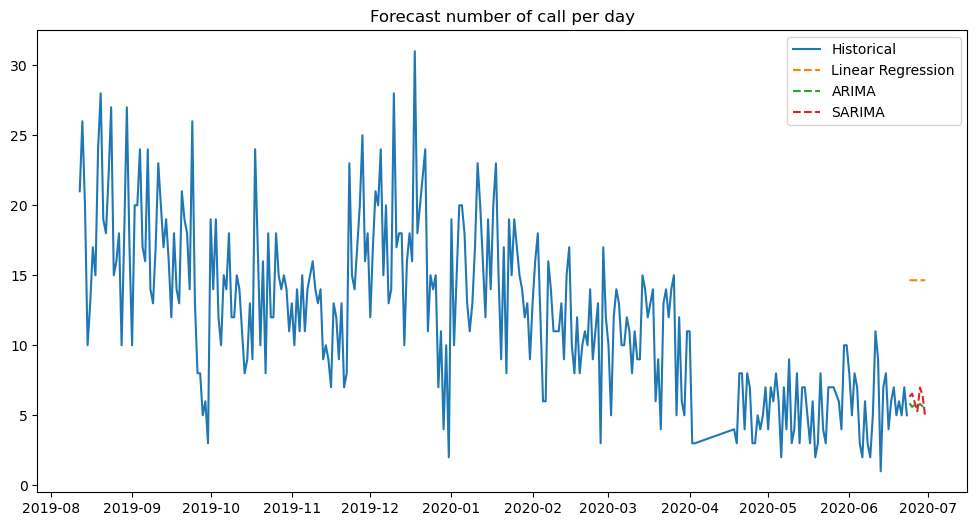

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(daily_calls[-300:], label='Historical') # Plot only last 60 days
plt.plot(forecast_dates, predictions_lr, label='Linear Regression', linestyle='--')
plt.plot(forecast_dates, predictions_arima, label='ARIMA', linestyle='--')
plt.plot(forecast_dates, predictions_sarima, label='SARIMA', linestyle='--')
plt.title('Forecast number of call per day')
plt.legend()
plt.show()

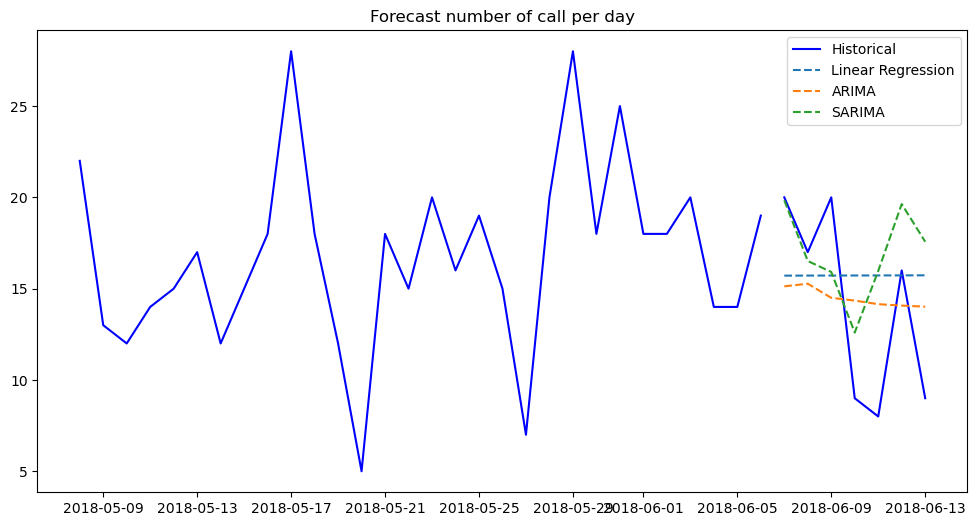

MAPE Linear Regression: 0.6133995795295863
MAPE ARIMA: 0.4956428565351268
MAPE SARIMA: 0.42029760035692665


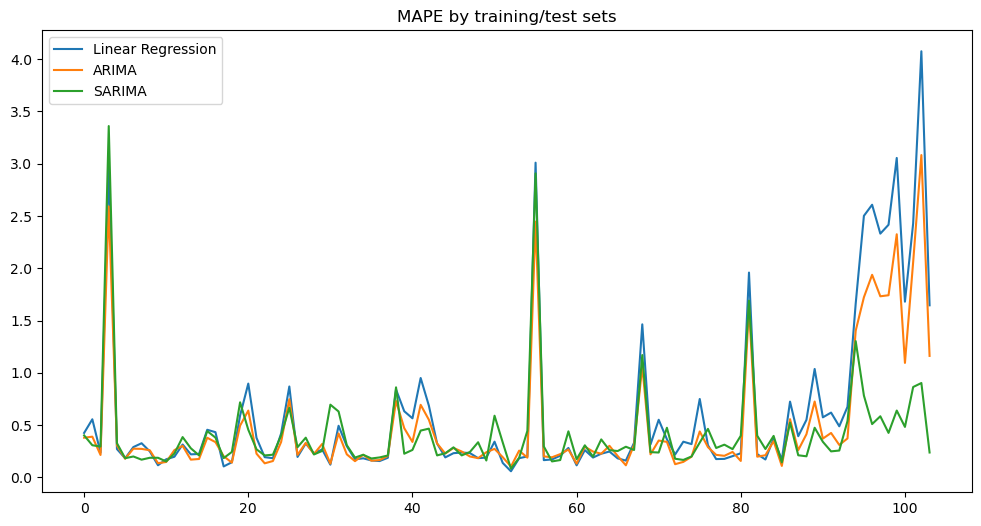

In [21]:
# Train and Test sets
window_size = 7 # number of days to forecast each time
train_size = len(daily_calls) - 730  # Use all data except two last years for cross validation
step_size = 7 # for cross validation

# MAPE scores
mape_scores_lr = []
mape_scores_arima = []
mape_scores_sarima = []

# Cross Validation
for start in range(train_size, len(daily_calls) - window_size, step_size):
    
    # Define train and test sets
    train = daily_calls[:start]
    test = daily_calls[start : start + window_size]

    # Linear Regression
    train_df = train.reset_index()
    train_df.columns = ['date', 'calls']
    train_df['days'] = (train_df['date'] - train_df['date'].min()).dt.days

    X_train = train_df[['days']]
    y_train = train_df['calls']
    model_lr = LinearRegression().fit(X_train, y_train)

    test_days = (test.index - train_df['date'].min()).days
    predictions_lr = model_lr.predict(test_days.values.reshape(-1, 1))

    # ARIMA
    model_arima = ARIMA(train, order=(2, 0, 0))  # Example orders (5, 1, 0)
    arima_fit = model_arima.fit()
    predictions_arima = arima_fit.forecast(steps=window_size)

    # SARIMA
    model_sarima = ARIMA(train, order=(5, 1, 0), seasonal_order=(5, 1, 0, 7))  # weekly seasonnality TBD
    sarima_fit = model_sarima.fit()
    predictions_sarima = sarima_fit.forecast(steps=window_size)

    # MAPE for the train/test sets
    mape_scores_lr.append(mean_absolute_percentage_error(test, predictions_lr))
    mape_scores_arima.append(mean_absolute_percentage_error(test, predictions_arima))
    mape_scores_sarima.append(mean_absolute_percentage_error(test, predictions_sarima))
    
    # Plot only first batch of the Cross Validation to check
    if start == train_size:
        forecast_dates = pd.date_range(start=test.index[0], end=test.index[-1])
        plt.figure(figsize=(12, 6))
        plt.plot(train[-30:], label='Historical', c="b")
        plt.plot(test, c="b")
        plt.plot(forecast_dates, predictions_lr, label='Linear Regression', linestyle='--')
        plt.plot(forecast_dates, predictions_arima, label='ARIMA', linestyle='--')
        plt.plot(forecast_dates, predictions_sarima, label='SARIMA', linestyle='--')
        plt.title('Forecast number of call per day')
        plt.legend()
        plt.show()

# Global MAPE
mape_global_lr = np.mean(mape_scores_lr)
mape_global_arima = np.mean(mape_scores_arima)
mape_global_sarima = np.mean(mape_scores_sarima)

print("MAPE Linear Regression:", mape_global_lr)
print("MAPE ARIMA:", mape_global_arima)
print("MAPE SARIMA:", mape_global_sarima)

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(mape_scores_lr, label='Linear Regression')
plt.plot(mape_scores_arima, label='ARIMA')
plt.plot(mape_scores_sarima, label='SARIMA')
plt.title('MAPE by training/test sets')
plt.legend()
plt.show()
